In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

You need to perform preprocessing on the given dataset. Please consider the following tasks and carry out the necessary steps accordingly.
- Handling missing values
- Handling outliers
- Scaling and normalization
- Feature Engineering
- Handling imbalanced data

In [2]:
# Load the diabetes dataset 
df = pd.read_csv('diabetes.csv')

full_df = pd.read_csv('full_df')

df.shape

(768, 9)

# Handling missing values

Skinthickness, Insulin and Pregancies have a high number of zeros

- Pregnant values might be real, but some might not considering how nulls are handleed in other columns
- Skinthickness, Insulin

BloodPressure Glucose and BMI only have a small number of zeros and can be replaced with a simple linear regression using the other two values 

In [3]:
def iszero(data):
    return data == 0
iszero(df).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

Masking approach, or sentinel approach

In [4]:
# Create a mask to identify rows with 4 or more zeros
mask = (df == 0).sum(axis=1) >= 4

# Drop rows with more than 3 zeros
filtered_df = df[~mask]

# Output the filtered DataFrame
filtered_df.shape

(724, 9)

<Axes: xlabel='Age', ylabel='BloodPressure'>

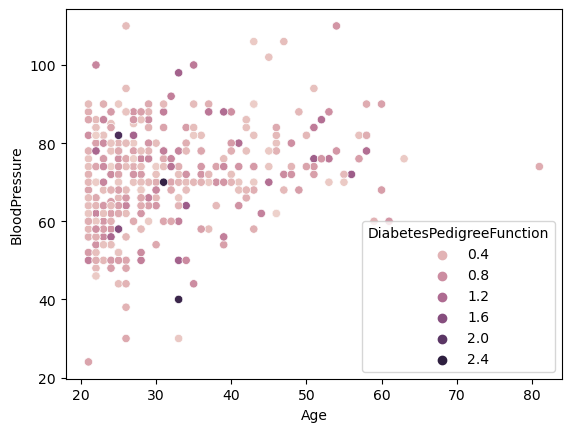

In [5]:
sns.scatterplot(data=full_df, x='Age', y='BloodPressure', hue='DiabetesPedigreeFunction')

# Feature Engineering


### Age Range

In [6]:
df.Age.value_counts().sort_index()

21    63
22    72
23    38
24    46
25    48
26    33
27    32
28    35
29    29
30    21
31    24
32    16
33    17
34    14
35    10
36    16
37    19
38    16
39    12
40    13
41    22
42    18
43    13
44     8
45    15
46    13
47     6
48     5
49     5
50     8
51     8
52     8
53     5
54     6
55     4
56     3
57     5
58     7
59     3
60     5
61     2
62     4
63     4
64     1
65     3
66     4
67     3
68     1
69     2
70     1
72     1
81     1
Name: Age, dtype: int64

In [7]:


# Define age bins and labels for the age ranges
age_bins = [20, 29, 39, 49, 59, float('inf')]  # Age bins
age_labels = ['20-29', '30-39', '40-49', '50-59', '60+']  # Corresponding labels

# Create 'AgeRange' column based on 'Age' column
df['AgeRange'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)





# Find mean BMI Glucose and Bloodpressure by age group

### Then replace nan values with the mean

In [8]:
#replace 0 with nan so that average doesn't include the zero values
low_zero_cols= ['Glucose','BloodPressure','BMI'] #cols with low zeros
mean_by_agerange={} #dictionary of age range means

for col in low_zero_cols:
    df[col].replace(0, np.nan, inplace=True)
    mean_by_agerange[col] = df.groupby('AgeRange')[col].mean()


In [9]:
for col in low_zero_cols:
    # replace nan in each col with the average of the age range groupby found in the dict mean_by_agerange
    df[col] = df.apply(lambda row: row[col] if not np.isnan(row[col]) else mean_by_agerange[col].get(row['AgeRange'], np.nan), axis=1)

<Axes: >

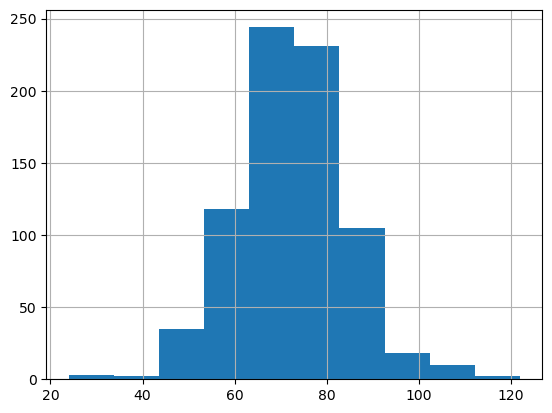

In [10]:
df.BloodPressure.hist()

# Replace Values in Skin thickenss with a linear regression of BMI, since there seems to be a good linear relationship

In [11]:
#replacing zeros with nans
df['SkinThickness'].replace(0, np.nan, inplace=True)

In [12]:
#replacing outlier with nan
#df['SkinThickness'].max() # removing 99 value value as it's likely an error
df['SkinThickness'].replace(99, np.nan, inplace=True)

In [13]:
df['SkinThickness'].corr(df['BMI'])

0.6732189693136361

<Axes: xlabel='BMI', ylabel='SkinThickness'>

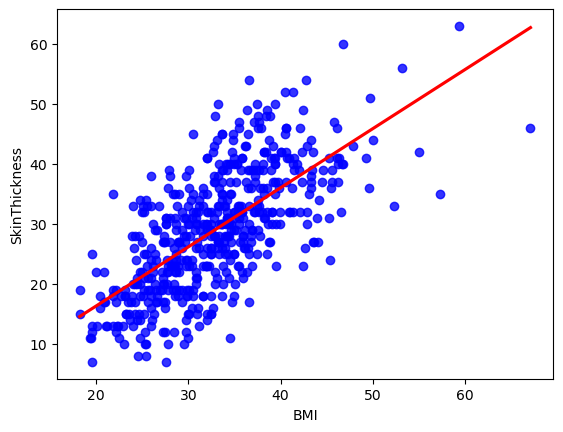

In [14]:
sns.regplot(x = "BMI", 
            y = "SkinThickness",  
            ci = None, 
            data = df, scatter_kws={"color": "blue"}, line_kws={"color": "red"}) 

Using a simple linear regression as the relationship looks strong and linear and other columns do not seem obviously related

In [15]:
df['SkinThickness'].replace(0, np.nan, inplace=True)

from sklearn.linear_model import LinearRegression



# Split data into two sets: one with non-null 'SkinThickness' values and one with null 'SkinThickness' values
train_data = df.dropna(subset=['SkinThickness'])
predict_data = df[df['SkinThickness'].isnull()]

# Prepare features (X) and target variable (y) for training the regression model
X_train = train_data[['BMI']]
y_train = train_data['SkinThickness']

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict 'SkinThickness' values for rows where 'SkinThickness' is NaN
predicted_skin_thickness = regressor.predict(predict_data[['BMI']])

# Fill NaN values in 'SkinThickness' column with predicted values
df.loc[df['SkinThickness'].isnull(), 'SkinThickness'] = predicted_skin_thickness



# Drop the column insulin?

In [16]:
#replacing zeros with nans
df['Insulin'].replace(0, np.nan, inplace=True)


Does the presence of 'insulin measurment predict outcome?

In [17]:

grouped = df.groupby(df['Insulin'].isnull())
print(grouped.Outcome.count())
print(grouped.Outcome.mean())

Insulin
False    394
True     374
Name: Outcome, dtype: int64
Insulin
False    0.329949
True     0.368984
Name: Outcome, dtype: float64


In [18]:
# there is a slightly higher chance those with an insulin measurement are positive but a small affect

In [19]:
#look are correlations for potenial linear relationships

correlation = df.corr()['Insulin']
correlation.sort_values(ascending=False)

C:\Users\user\AppData\Local\Temp\ipykernel_708\720958041.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()['Insulin']


Insulin                     1.000000
Glucose                     0.581031
Outcome                     0.303454
BMI                         0.228186
Age                         0.220261
SkinThickness               0.184888
DiabetesPedigreeFunction    0.130395
BloodPressure               0.098272
Pregnancies                 0.082171
Name: Insulin, dtype: float64

<Axes: xlabel='Glucose', ylabel='Insulin'>

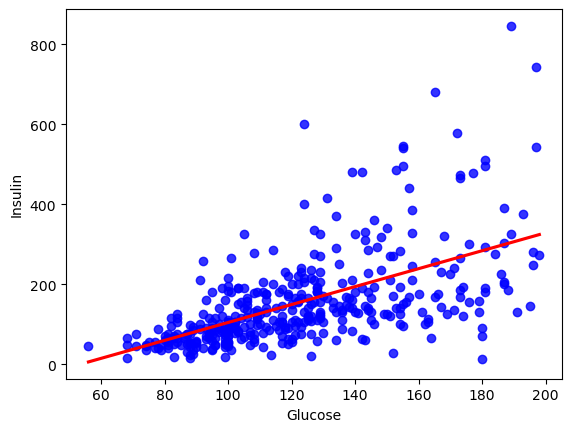

In [20]:
# Looking at the column with the best correlation 

sns.regplot(x = "Glucose", 
            y = "Insulin",  
            ci = None, 
   
            data = df, scatter_kws={"color": "blue"}, line_kws={"color": "red"}) 

In [21]:
#decent correlation at the lower ends, larger spread once higher

<Axes: xlabel='Glucose', ylabel='Insulin'>

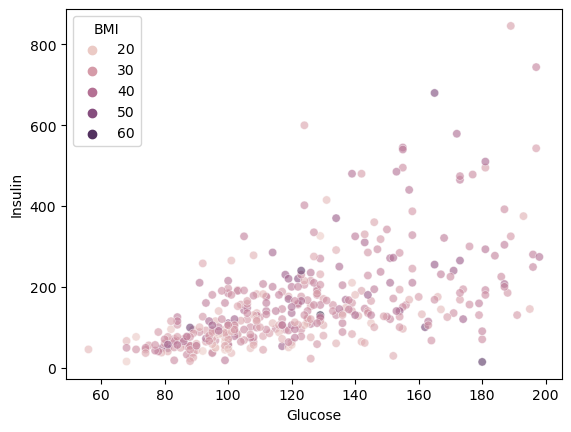

In [22]:
sns.scatterplot(data=full_df, x='Glucose', y='Insulin', hue='BMI', alpha=0.6)

In [23]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

# Excluding columns 'Pregnancies' and 'Outcome'
impute_columns = ['Glucose', 'Insulin','BMI','Age','SkinThickness','DiabetesPedigreeFunction','BloodPressure']

# Use KNNImputer to fill NaN values in the specified columns
imputed_data = imputer.fit_transform(df[impute_columns])

# Update the DataFrame with imputed values
df[impute_columns] = imputed_data


<Axes: >

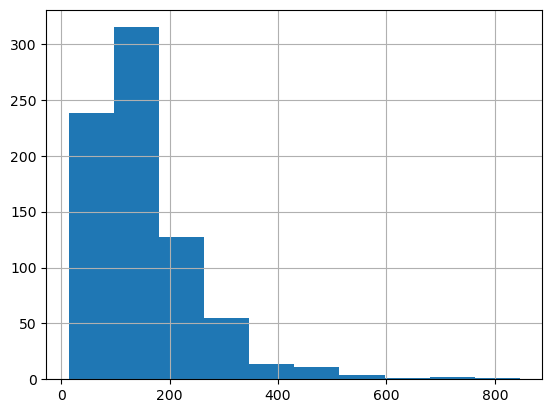

In [24]:
df.Insulin.hist()

<Axes: xlabel='Glucose', ylabel='Insulin'>

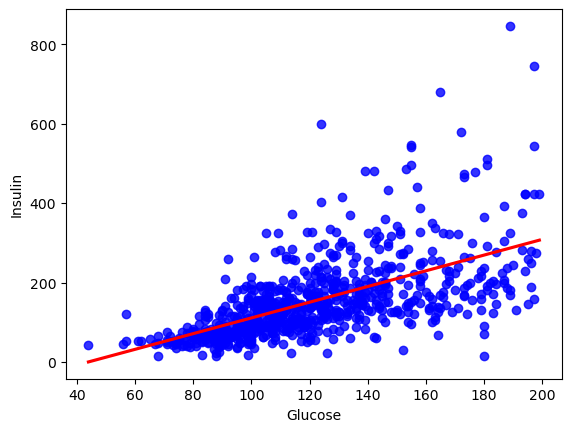

In [25]:
#look at Insulin after imputation 

sns.regplot(x = "Glucose", 
            y = "Insulin",  
            ci = None, 
   
            data = df, scatter_kws={"color": "blue"}, line_kws={"color": "red"}) 

### since there are so many "nulls" for insulin I will likely not include this column in the future models despite imputing 

# Handling outliers


In [26]:
# for any outliers I will scale them to the IR*1.5 for the upper and lower bounds


In [27]:
X_col_names=df.columns.values[:-2]

X_col_names

array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype=object)

<Axes: >

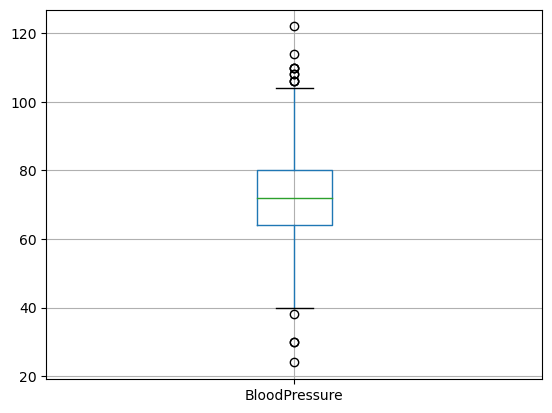

In [28]:

df.boxplot(column='BloodPressure')

In [29]:
X_col_names

array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype=object)

In [30]:
for col in X_col_names:
    # Calculate the IQR for col
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #Replace outliers with IQR*1.5 i.e the whisker value in the boxplots 
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

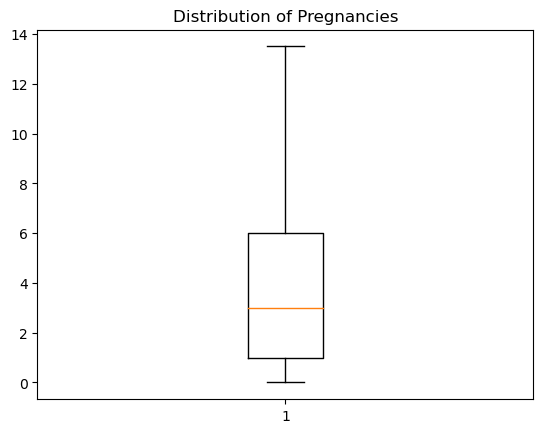

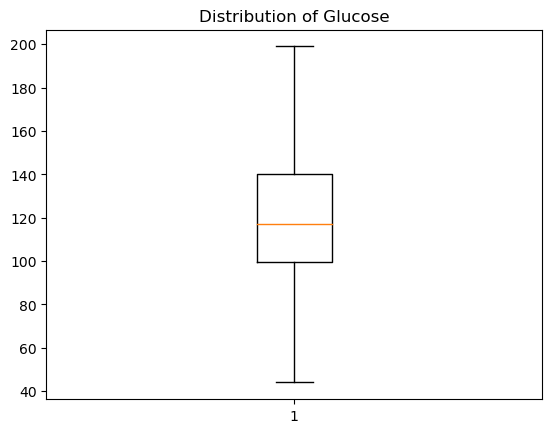

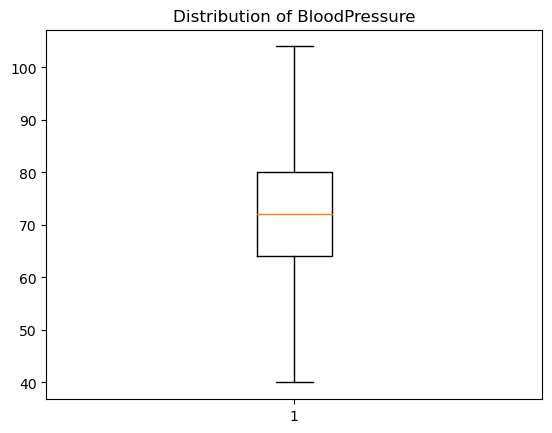

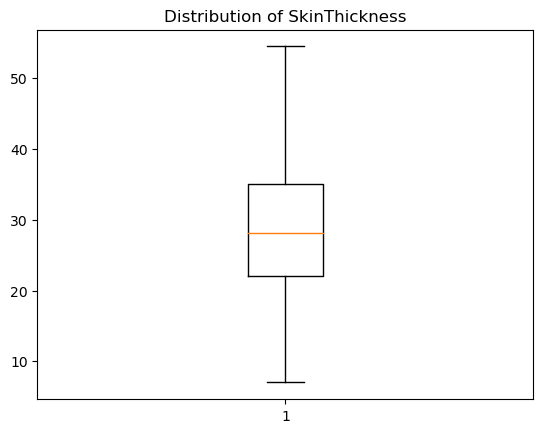

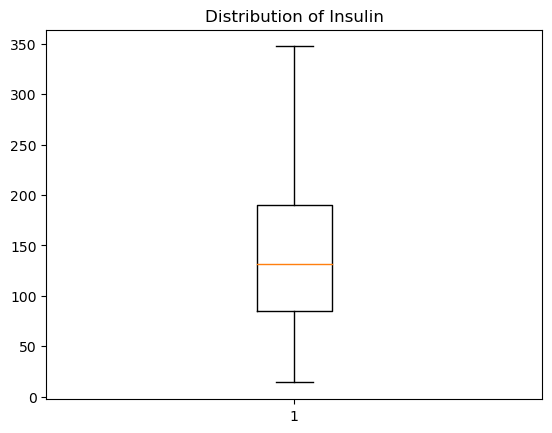

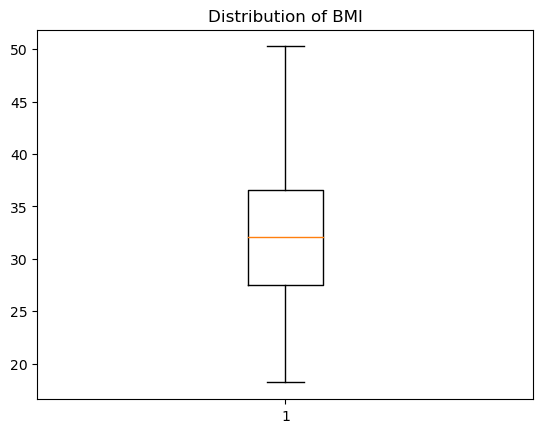

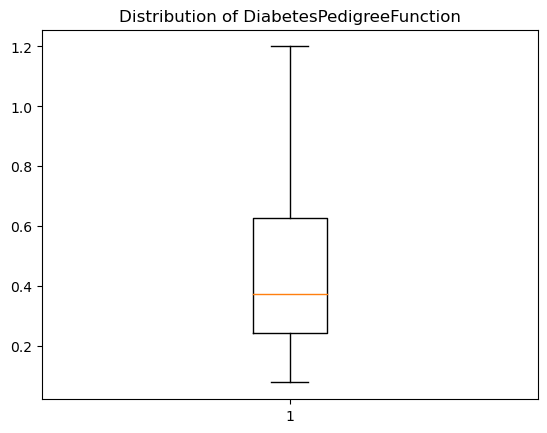

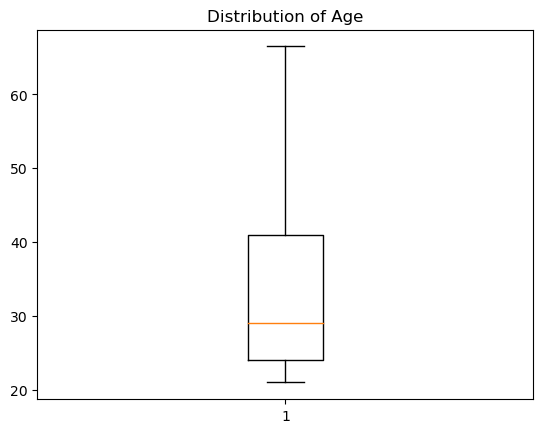

In [31]:

for col in X_col_names:
    title = f'Distribution of {col}'
    x_label = f'{col} bins'
    
    plt.boxplot(df[col])

    plt.title(title)
    plt.show()

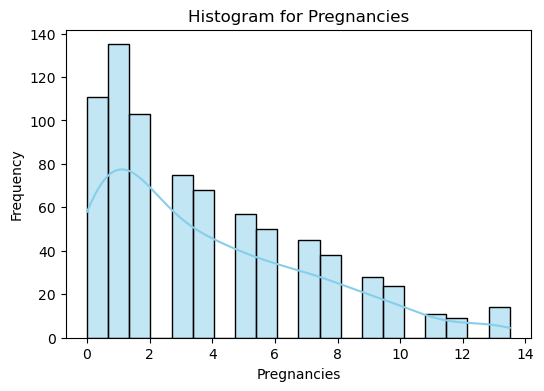

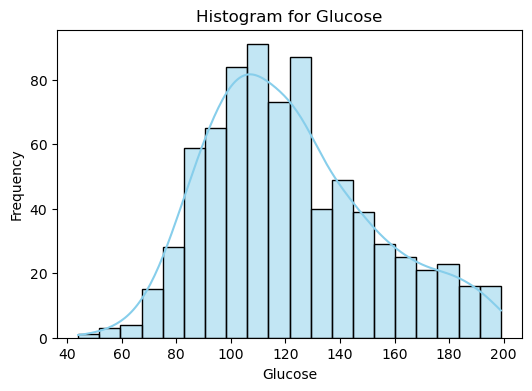

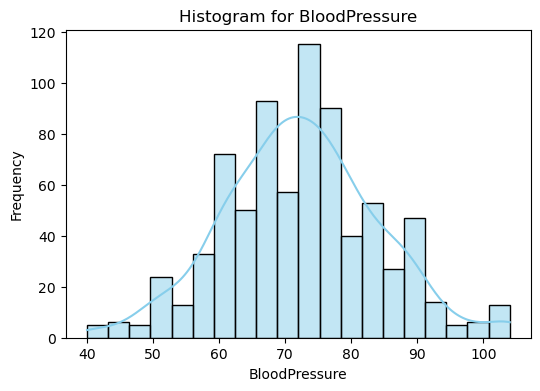

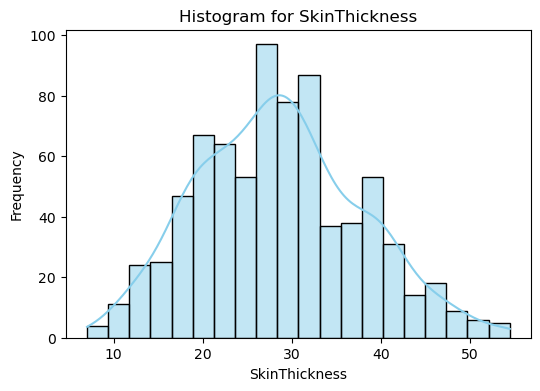

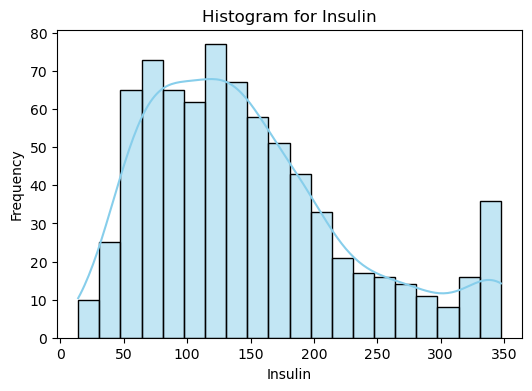

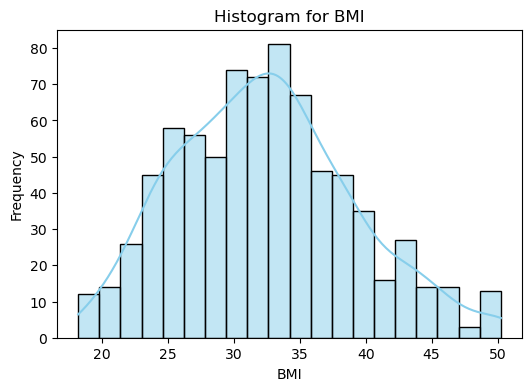

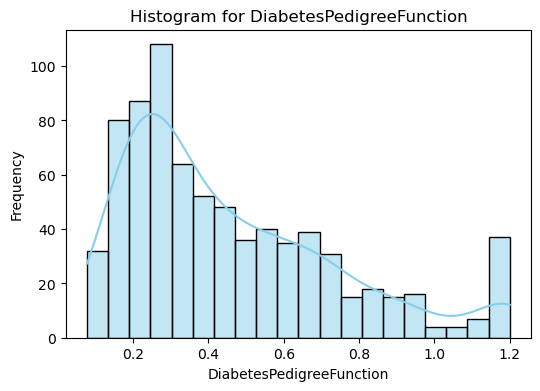

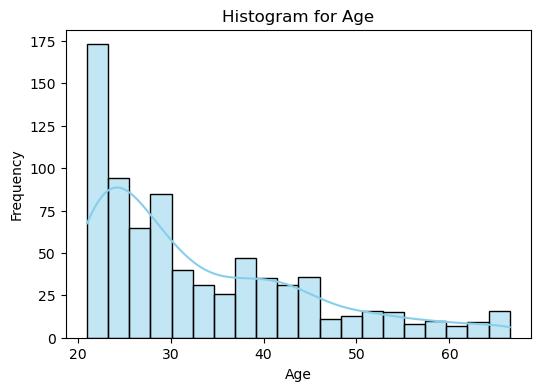

In [32]:
# Plot histograms for each column in X_col_names
for col in X_col_names:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [36]:
unscaled_df = df.copy()

# Scaling and Normalizing Data

In [323]:
from sklearn.preprocessing import StandardScaler

#so they have a mean of 0 and a standard deviation of 1

columns_to_scale = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


scaler = StandardScaler()



df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


df.head()



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeRange,skin_ratio,big_sweet,full_stack,PregnanciesPerYearOver16
0,0.647150,0.865685,-0.028802,0.704332,-0.281288,0.182191,0.588927,1.445691,1,50-59,3.865909,1.047876,4.123886,0.176471
1,-0.848970,-1.205255,-0.541095,0.047163,-1.006891,-0.868176,-0.378101,-0.189304,0,30-39,-0.054324,-2.073431,-4.990629,0.066667
2,1.245598,2.016208,-0.711859,-0.984718,-0.314270,-1.363349,0.746595,-0.103252,1,30-39,0.722279,0.652859,0.530952,0.500000
3,-0.848970,-1.073767,-0.541095,-0.610007,-0.668826,-0.643098,-1.022787,-1.049828,0,20-29,0.948544,-1.716864,-6.458377,0.200000
4,-1.148194,0.504093,-2.761032,0.704332,0.246422,1.607688,2.596563,-0.017199,1,30-39,0.438102,2.111781,1.732673,0.000000


In [40]:
unscaled_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeRange
0,6.0,148.0,72.0,35.000000,125.333333,33.6,0.627,50.0,1,50-59
1,1.0,85.0,66.0,29.000000,66.666667,26.6,0.351,31.0,0,30-39
2,8.0,183.0,64.0,19.578856,122.666667,23.3,0.672,32.0,1,30-39
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0,20-29
4,0.0,137.0,40.0,35.000000,168.000000,43.1,1.200,33.0,1,30-39


# Plot histograms for each column in X_col_names


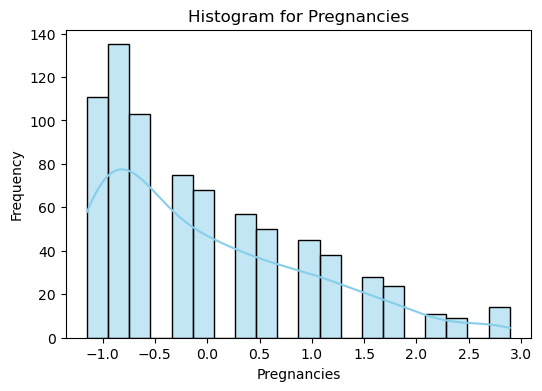

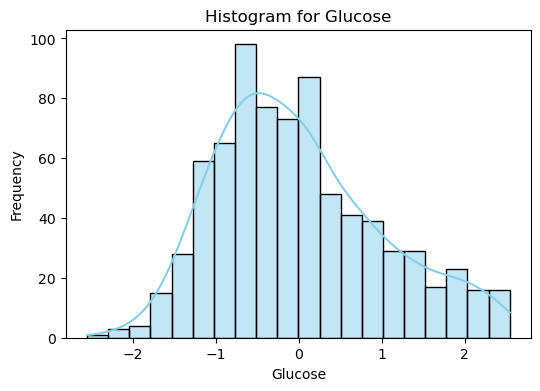

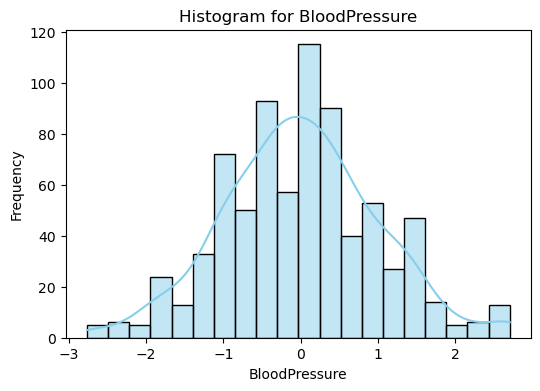

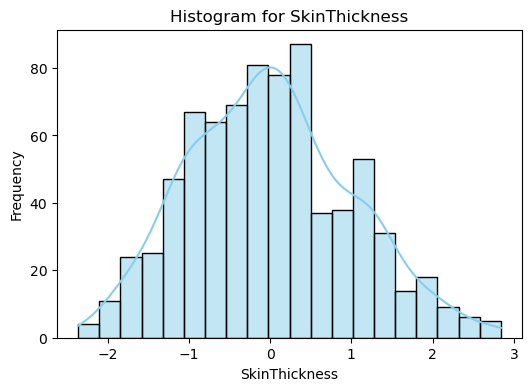

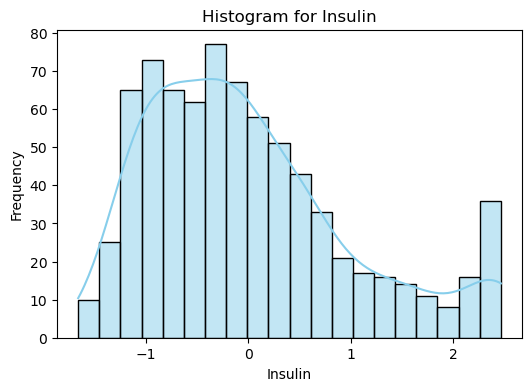

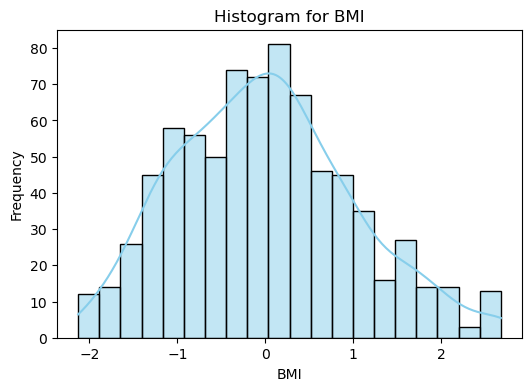

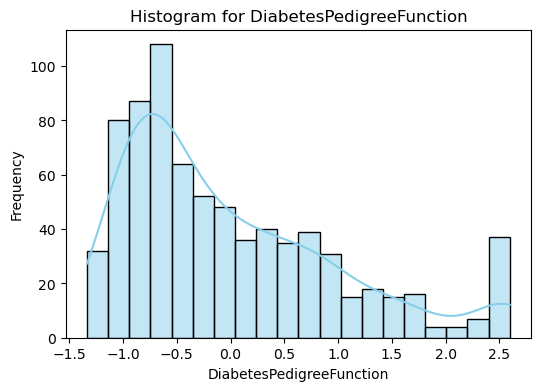

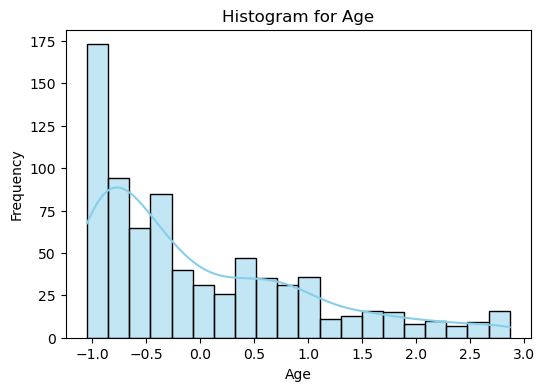

In [41]:
for col in X_col_names:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Feature Engineering

In [42]:
unscaled_df['PregnanciesPerYearOver16']=unscaled_df['Pregnancies']/(unscaled_df['Age']-16)

<Axes: >

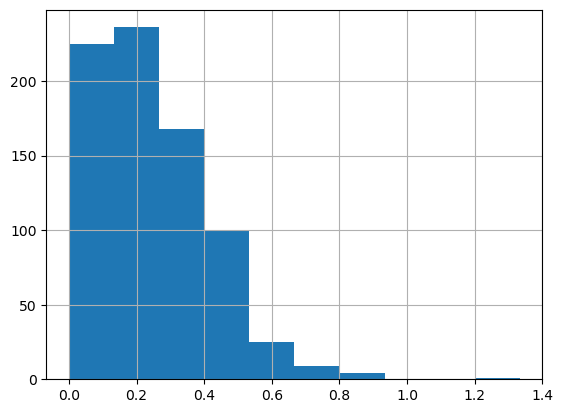

In [43]:
unscaled_df['PregnanciesPerYearOver16'].hist()

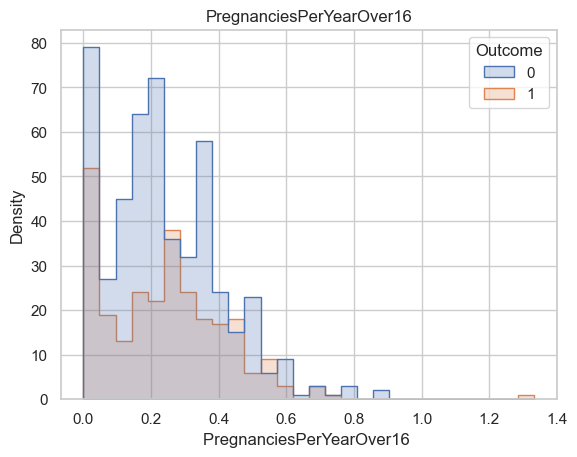

In [45]:
sns.set(style="whitegrid")


sns.histplot(data=unscaled_df, x='PregnanciesPerYearOver16', hue=df['Outcome'], element='step', common_norm=False)

# Adding labels and title
plt.xlabel('PregnanciesPerYearOver16 ')
plt.ylabel('Density')
plt.title('PregnanciesPerYearOver16')

# Display the plot
plt.show()

In [71]:
# Merge 'PregnanciesPerYearOver16' from 'unscaled_df' to 'df' based on the index
df = pd.merge(df, unscaled_df[['PregnanciesPerYearOver16']], left_index=True, right_index=True)



In [55]:
unscaled_df['skin_ratio']=unscaled_df['SkinThickness']/(unscaled_df['BMI'])

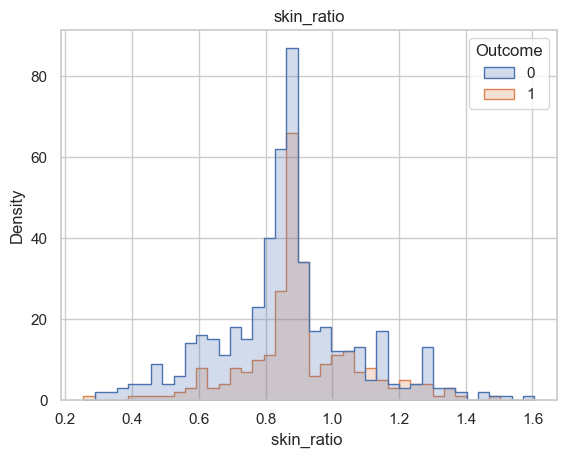

In [56]:
sns.set(style="whitegrid")


sns.histplot(data=unscaled_df, x='skin_ratio', hue=unscaled_df['Outcome'], element='step', common_norm=False)

# Adding labels and title
plt.xlabel('skin_ratio ')
plt.ylabel('Density')
plt.title('skin_ratio')

# Display the plot
plt.show()

In [57]:
df['big_sweet']=df['Glucose']+(df['BMI'])

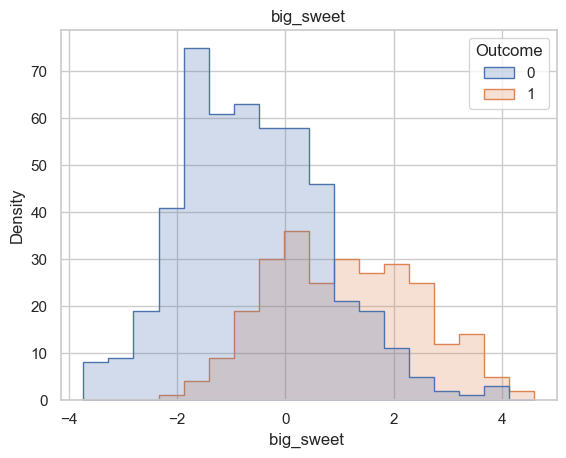

In [58]:
sns.set(style="whitegrid")


sns.histplot(data=df, x='big_sweet', hue=df['Outcome'], element='step', common_norm=False)

# Adding labels and title
plt.xlabel('big_sweet ')
plt.ylabel('Density')
plt.title('big_sweet')

# Display the plot
plt.show()

In [ ]:
df['full_stack'] = df[X_col_names].sum(axis=1)

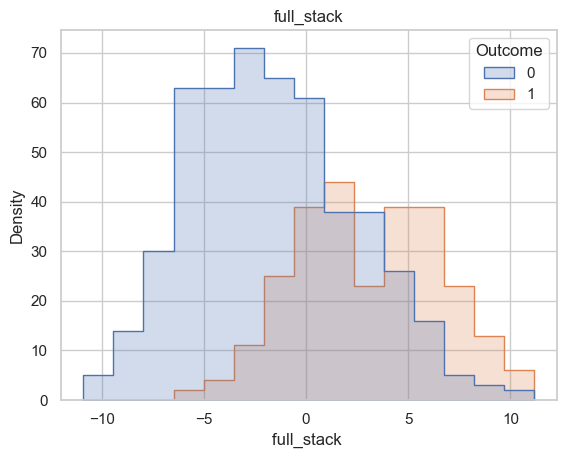

In [62]:
sns.set(style="whitegrid")


sns.histplot(data=df, x='full_stack', hue=df['Outcome'], element='step', common_norm=False)

# Adding labels and title
plt.xlabel('full_stack ')
plt.ylabel('Density')
plt.title('full_stack')

# Display the plot
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_708\3508605660.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[df['AgeRange']==age].corr()['Outcome']


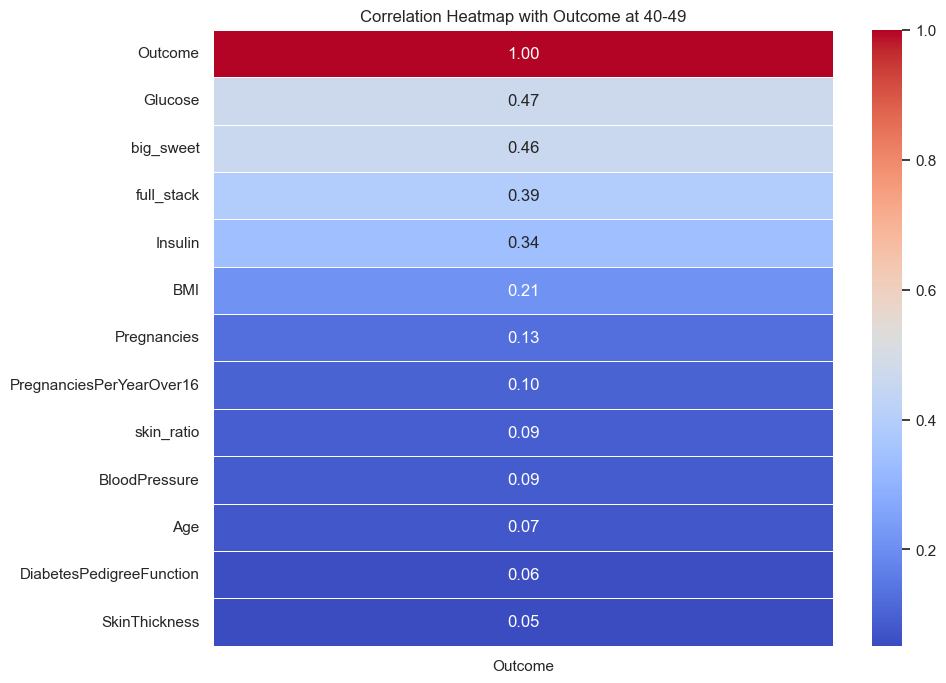

C:\Users\user\AppData\Local\Temp\ipykernel_708\3508605660.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[df['AgeRange']==age].corr()['Outcome']


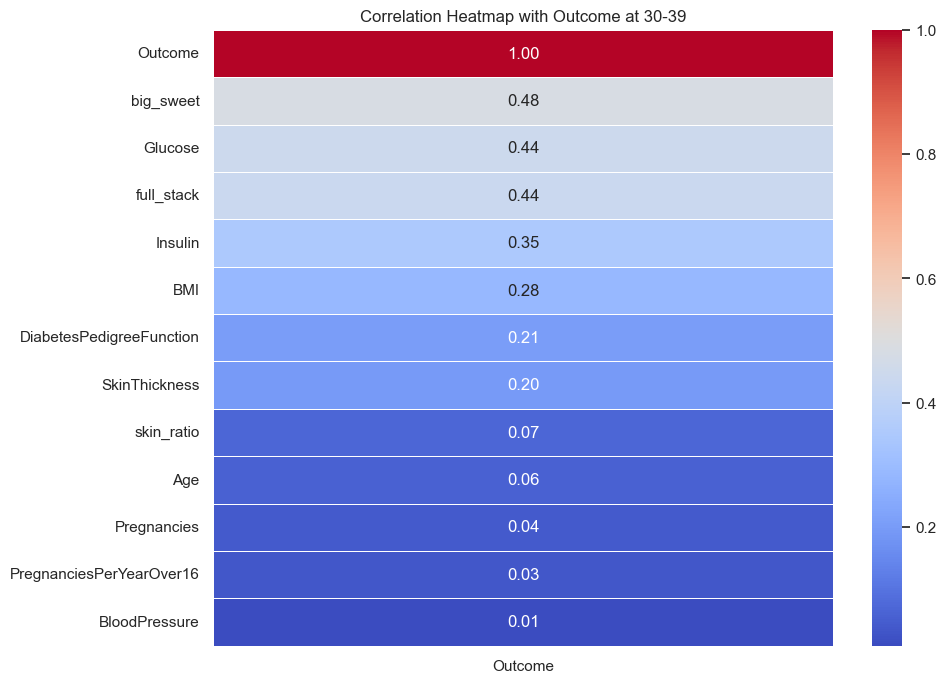

C:\Users\user\AppData\Local\Temp\ipykernel_708\3508605660.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[df['AgeRange']==age].corr()['Outcome']


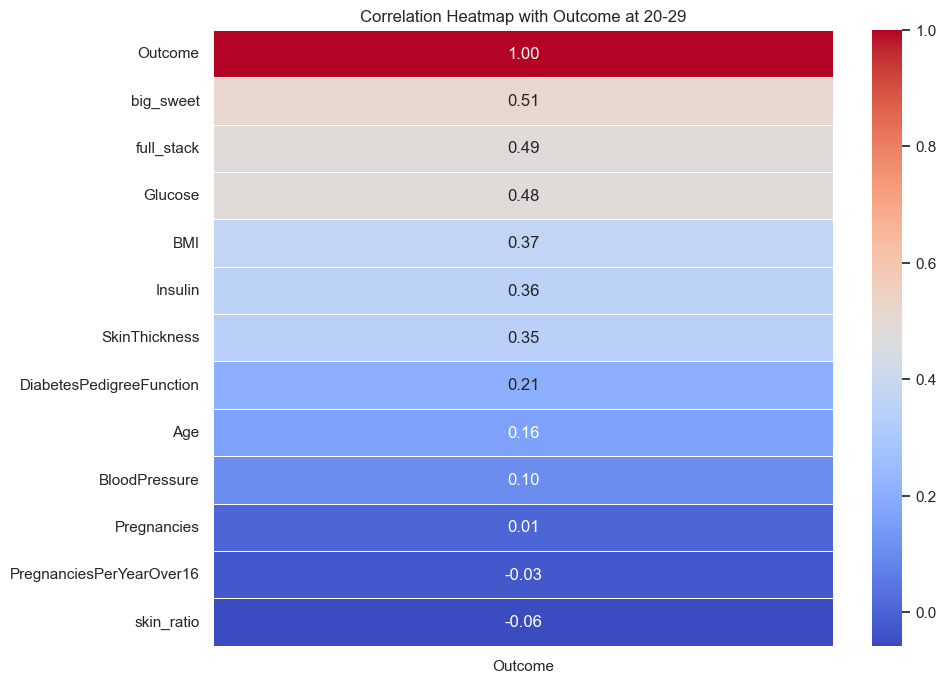

C:\Users\user\AppData\Local\Temp\ipykernel_708\3508605660.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[df['AgeRange']==age].corr()['Outcome']


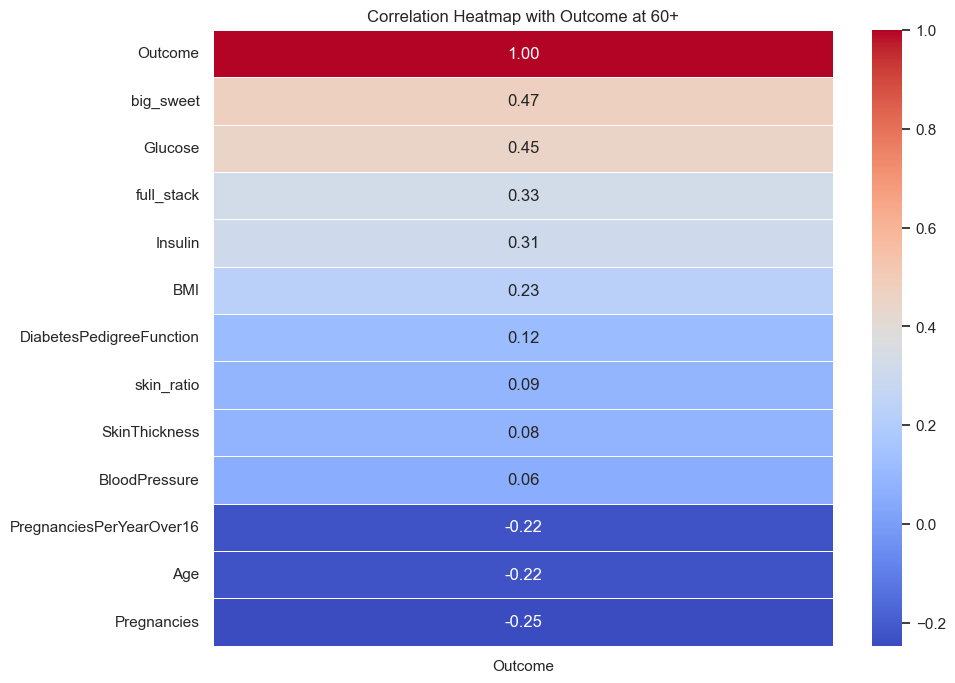

C:\Users\user\AppData\Local\Temp\ipykernel_708\3508605660.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[df['AgeRange']==age].corr()['Outcome']


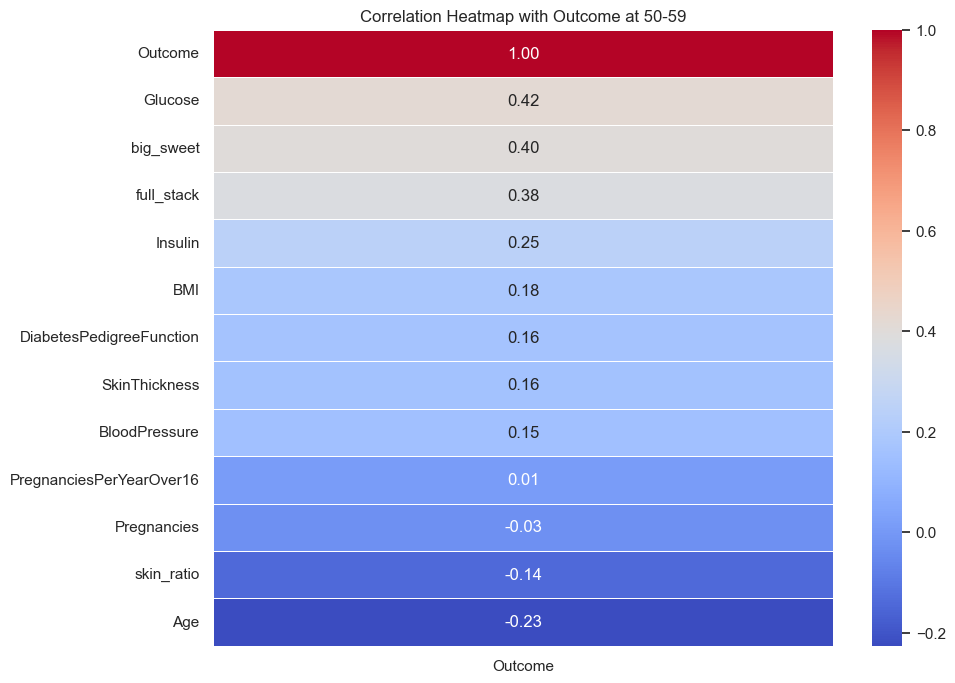

In [72]:
agerange=set(df.AgeRange)

for age in agerange:
    correlation_matrix = df[df['AgeRange']==age].corr()['Outcome']

    # Create a heatmap using Seaborn
    plt.figure(figsize=(10, 8))  
    sns.heatmap(data=correlation_matrix.sort_values(ascending = False).to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Heatmap with Outcome at {age}')
    plt.show()

In [65]:
set(df.AgeRange)

{'20-29', '30-39', '40-49', '50-59', '60+'}

In [68]:
df[df['AgeRange']=='20-29']

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeRange,skin_ratio,big_sweet,full_stack
3,-0.848970,-1.073767,-0.541095,-0.610007,-0.668826,-0.643098,-1.022787,-1.049828,0,20-29,0.948544,-1.716864,-6.458377
6,-0.250522,-1.435360,-1.907210,0.375747,-0.743035,-0.207946,-0.738985,-0.619566,1,20-29,-1.806950,-1.643305,-5.526876
20,-0.250522,0.142500,1.337313,1.361502,1.075093,1.037489,0.858714,-0.533513,0,20-29,1.312304,1.179989,5.028575
27,-0.848970,-0.810790,-0.541095,-1.486232,-0.099888,-1.378354,0.098405,-0.963775,0,20-29,1.078266,-2.189145,-6.030699
31,-0.250522,1.194406,0.312727,0.813860,1.198775,-0.117914,1.373762,-0.447461,1,20-29,-6.902139,1.076492,4.077633
...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,-1.148194,1.950464,1.337313,1.690086,2.466517,1.637699,-0.830082,-0.619566,1,20-29,1.031989,3.588162,6.484237
758,-0.848970,-0.514942,0.312727,0.547299,0.530891,0.767395,-0.917676,-0.619566,0,20-29,0.713191,0.252453,-0.742841
760,-0.549746,-1.106639,-1.224152,-0.281422,-1.633547,-0.598082,1.075945,-0.963775,0,20-29,0.470541,-1.704721,-5.281418
764,-0.549746,0.011011,-0.199566,-0.171894,0.229931,0.662358,-0.416642,-0.533513,0,20-29,-0.259518,0.673370,-0.968061


In [77]:
from sklearn.utils import resample
# Separate majority and minority classes
majority_class = df[df['Outcome'] == 0]
minority_class = df[df['Outcome'] == 1]

# Resample the majority class to match the number of minority class samples
majority_resampled = resample(majority_class, replace=True, n_samples=len(minority_class), random_state=42)

# Combine minority class with resampled majority class
balanced_df = pd.concat([minority_class, majority_resampled])

# Shuffle the DataFrame (optional)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)



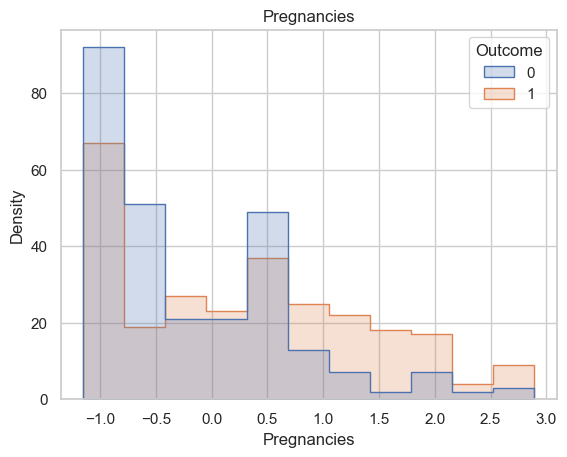

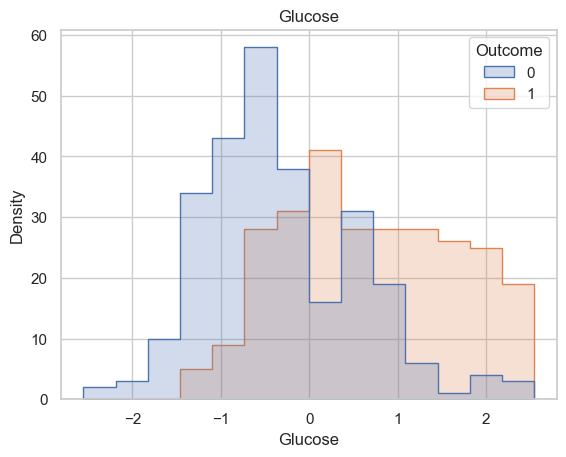

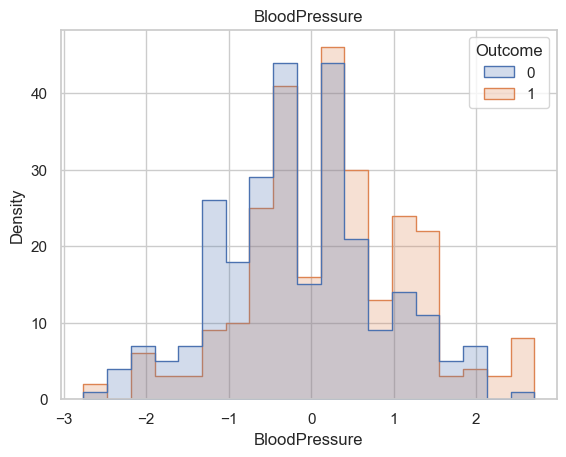

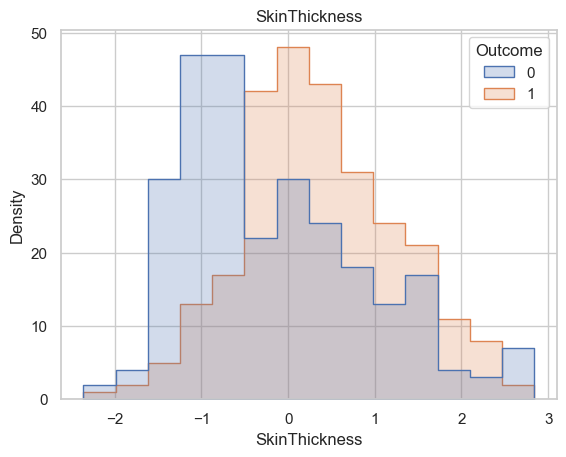

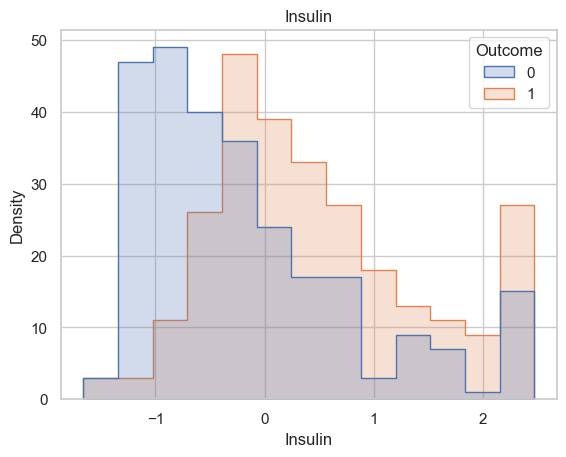

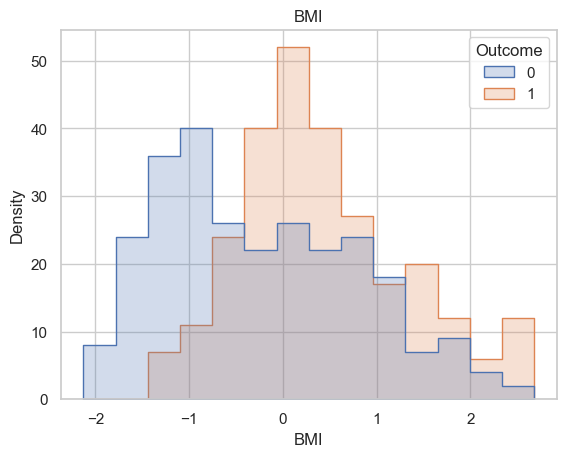

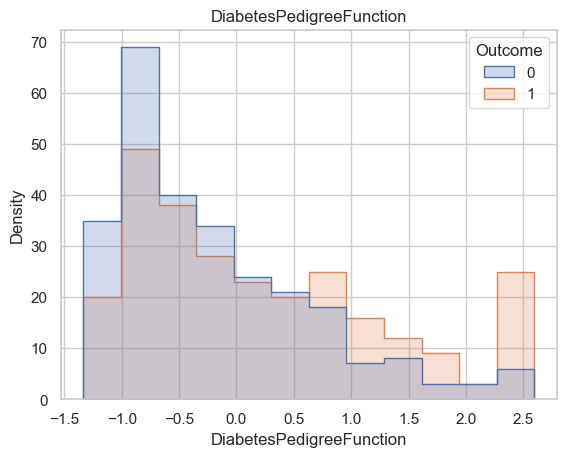

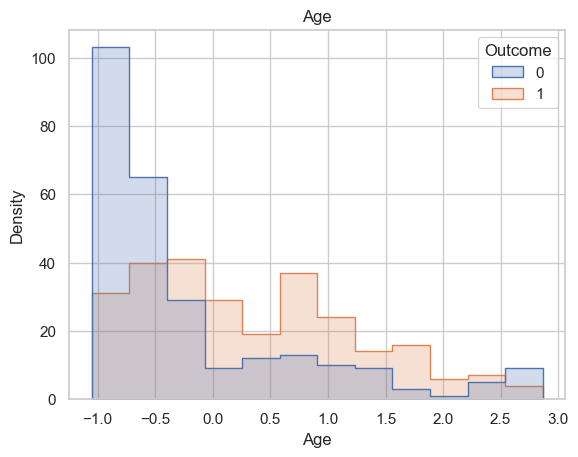

In [76]:
for col in X_col_names:

    
    sns.set(style="whitegrid")


    sns.histplot(data=balanced_df, x=col, hue=balanced_df['Outcome'], element='step', common_norm=False)

    # Adding labels and title
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.title(f'{col}')

    # Display the plot
    plt.show()

In [78]:
balanced_df.to_csv('balanced_df')

# dropping insulin and 0 preganacies and seeing to compare models in later notebook

In [299]:
#getting raw_data
df_full = pd.read_csv('diabetes.csv')
df_pregnant = pd.read_csv('diabetes.csv')
df_no_insulin = pd.read_csv('diabetes.csv')

#differenciating dfs
df_pregnant=df_pregnant[df_pregnant['Pregnancies']!=0]
drop_insulin(df_no_insulin)
#list of dfs to be processed
dfs= [df_full, df_no_insulin,df_pregnant]

In [300]:
# Define age bins and labels for the age ranges
age_bins = [20, 29, 39, 49, 59, float('inf')]  # Age bins
age_labels = ['20-29', '30-39', '40-49', '50-59', '60+']  # Corresponding labels


def add_unscaled_features(df):
    df['AgeRange'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
    df['skin_ratio']=df['SkinThickness']/(unscaled_df['BMI'])
    df['PregnanciesPerYearOver16']=df['Pregnancies']/(df['Age']-16)
    return df

# Applying the function to each DataFrame in the list
dfs_with_new_columns = list(map(add_unscaled_features, dfs))

In [301]:
#replace 0 with nan so that average doesn't include the zero values
low_zero_cols= ['Glucose','BloodPressure','BMI'] #cols with low zeros
mean_by_agerange={} #dictionary of age range means

def replace_avg_value_by_age_range(df):
    for col in low_zero_cols:
        df[col].replace(0, np.nan, inplace=True)
        mean_by_agerange[col] = df.groupby('AgeRange')[col].mean()

    for col in low_zero_cols:
        # replace nan in each col with the average of the age range groupby found in the dict mean_by_agerange
        df[col] = df.apply(lambda row: row[col] if not np.isnan(row[col]) else mean_by_agerange[col].get(row['AgeRange'], np.nan), axis=1)
    return df
dfs_with_zeros_replaced = list(map(replace_avg_value_by_age_range, dfs))

In [302]:
def remove_outliers(df):
    df_copy = df.copy()
    X_col_names = df.select_dtypes(include=np.number).columns.tolist()  # Select numeric columns
    X_col_names.remove('Outcome')  # Exclude the 'Outcome' column
    for col in X_col_names:
        # Calculate the IQR for col
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        #Replace outliers with IQR*1.5 i.e the whisker value in the boxplots 
        df_copy[col] = np.where(df_copy[col] < lower_bound, lower_bound, df_copy[col])
        df_copy[col] = np.where(df_copy[col] > upper_bound, upper_bound, df_copy[col])
    return df_copy
dfs_outliers_removed=list(map(remove_outliers, dfs))

In [303]:
def convert_age_range_to_int(df):

    age_range_mapping = {
        '20-29': 1,
        '30-39': 2,
        '40-49': 3,
        '50-59': 4,
        '60+': 5}

    # Convert 'AgeRange' to integers using the mapping
    df['AgeRange'] = df['AgeRange'].map(age_range_mapping)
    return df
dfs_age_to_integer=list(map(convert_age_range_to_int, dfs))

In [326]:
def scale_columns(df):
    
    X_col_names = df.select_dtypes(include=np.number).columns.tolist()  # Select numeric columns
    X_col_names.remove('Outcome')  # Exclude the 'Outcome' column
    print(f"Columns to scale: {X_col_names}")
    
    scaler = StandardScaler()
    df[X_col_names] = scaler.fit_transform(df[X_col_names])
    
    return df

dfs_scaled_columns = list(map(scale_columns, dfs))

df_full.head()

Columns to scale: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'skin_ratio', 'PregnanciesPerYearOver16', 'big_sweet']
Columns to scale: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'skin_ratio', 'PregnanciesPerYearOver16', 'big_sweet']
Columns to scale: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'skin_ratio', 'PregnanciesPerYearOver16', 'big_sweet']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeRange,skin_ratio,PregnanciesPerYearOver16,big_sweet
0,0.639947,0.865685,-0.030219,0.907270,-0.692891,0.167686,0.468492,1.425995,1,4,0.928996,-0.333764,0.840405
1,-0.844885,-1.205255,-0.525651,0.530902,-0.692891,-0.850949,-0.365061,-0.190672,0,2,1.036139,-0.964845,-1.299796
2,1.233880,2.016208,-0.690796,-1.288212,-0.692891,-1.331162,0.604397,-0.105584,1,2,-1.369400,1.525670,1.595591
3,-0.844885,-1.073767,-0.525651,0.154533,0.123302,-0.632670,-0.920763,-1.041549,0,1,0.436599,-0.198533,-1.131637
4,-1.141852,0.504093,-2.672525,0.907270,0.765836,1.550120,5.484909,-0.020496,1,2,0.422389,-1.348001,0.794544


In [338]:
def add_scaled_features(df):
    col_names=['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
    selected_col_names = [col for col in col_names if col in df.columns]
    df['big_sweet']=df['Glucose']+(df['BMI'])
    df['full_stack'] = df[selected_col_names].sum(axis=1)
    return df

# Applying the function to each DataFrame in the list
dfs_with_new_column = list(map(add_scaled_features, dfs))

In [306]:
def balance_dfs(df):
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Resample the majority class to match the number of minority class samples
    majority_resampled = resample(majority_class, replace=True, n_samples=len(minority_class), random_state=9898)

    # Combine minority class with resampled majority class
    df = pd.concat([minority_class, majority_resampled])
    
    return df

In [328]:
balance_dfs(df_full)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeRange,skin_ratio,PregnanciesPerYearOver16,big_sweet
0,0.639947,0.865685,-0.030219,0.907270,-0.692891,0.167686,0.468492,1.425995,1,4,0.928996,-0.333764,1.033372
2,1.233880,2.016208,-0.690796,-1.288212,-0.692891,-1.331162,0.604397,-0.105584,1,2,-1.369400,1.525670,0.685045
4,-1.141852,0.504093,-2.672525,0.907270,0.765836,1.550120,5.484909,-0.020496,1,2,0.422389,-1.348001,2.054212
6,-0.250952,-1.435360,-1.846804,0.719086,0.071204,-0.210664,-0.676133,-0.616111,1,1,0.908236,0.376201,-1.646023
8,-0.547919,2.476417,-0.195363,1.534551,4.021922,-0.283423,-0.947944,1.681259,1,4,1.886032,-1.037334,2.192993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,-0.844885,-1.040895,-0.855940,-0.535475,-0.319526,-0.763637,0.326546,-0.786286,0,1,-0.395962,-0.629584,-1.804532
450,-0.844885,-1.303871,-0.690796,-0.472747,0.131985,-1.636753,-0.171773,-0.871374,0,1,-0.016382,-0.526952,-2.940624
491,-0.547919,-1.073767,1.456078,0.593630,-0.692891,0.153134,-0.543248,0.745293,0,3,0.606534,-0.905898,-0.920632
478,1.233880,0.142500,0.134925,1.095454,-0.041673,-0.952812,-0.935863,0.490030,0,3,1.867877,0.651074,-0.810312


In [329]:

balance_dfs(df_no_insulin)

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeRange,skin_ratio,PregnanciesPerYearOver16,big_sweet
0,0.639947,0.865685,-0.030219,0.907270,0.167686,0.468492,1.425995,1,4,0.928996,-0.333764,1.033372
2,1.233880,2.016208,-0.690796,-1.288212,-1.331162,0.604397,-0.105584,1,2,-1.369400,1.525670,0.685045
4,-1.141852,0.504093,-2.672525,0.907270,1.550120,5.484909,-0.020496,1,2,0.422389,-1.348001,2.054212
6,-0.250952,-1.435360,-1.846804,0.719086,-0.210664,-0.676133,-0.616111,1,1,0.908236,0.376201,-1.646023
8,-0.547919,2.476417,-0.195363,1.534551,-0.283423,-0.947944,1.681259,1,4,1.886032,-1.037334,2.192993
...,...,...,...,...,...,...,...,...,...,...,...,...
353,-0.844885,-1.040895,-0.855940,-0.535475,-0.763637,0.326546,-0.786286,0,1,-0.395962,-0.629584,-1.804532
450,-0.844885,-1.303871,-0.690796,-0.472747,-1.636753,-0.171773,-0.871374,0,1,-0.016382,-0.526952,-2.940624
491,-0.547919,-1.073767,1.456078,0.593630,0.153134,-0.543248,0.745293,0,3,0.606534,-0.905898,-0.920632
478,1.233880,0.142500,0.134925,1.095454,-0.952812,-0.935863,0.490030,0,3,1.867877,0.651074,-0.810312


In [330]:
balance_dfs(df_pregnant)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeRange,skin_ratio,PregnanciesPerYearOver16,big_sweet
0,0.468243,0.868146,-0.011663,0.937143,-0.691310,0.251547,0.521014,1.338455,1,4,0.915837,-0.623867,1.119693
2,1.090358,2.011647,-0.669992,-1.285611,-0.691310,-1.350744,0.664503,-0.185721,1,2,-1.359767,1.442066,0.660903
6,-0.464929,-1.418856,-1.822067,0.746621,0.074082,-0.152915,-0.687489,-0.693780,1,1,0.895283,0.164944,-1.571770
8,-0.775986,2.469047,-0.176245,1.572216,4.031507,-0.230696,-0.974468,1.592485,1,4,1.863384,-1.405572,2.238351
9,1.090358,0.116703,1.963323,-1.285611,-0.691310,-0.023187,-0.738508,1.677161,1,4,-1.359767,-0.406401,0.093516
...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,-0.464929,-0.732755,-1.492903,-0.078973,0.056687,-0.992951,-0.987223,-0.863133,0,1,0.261601,0.643865,-1.725706
566,-1.087043,-0.732755,-0.011663,0.619607,-0.534752,1.029358,-0.164549,-1.117162,0,1,0.338093,-0.473618,0.296603
553,-1.087043,-1.092141,-0.834574,0.238563,-0.308614,-0.324033,-0.132662,-0.947809,0,1,0.393742,-0.838510,-1.416174
497,-0.775986,-1.320841,-0.011663,-0.333002,-0.030289,-0.292921,0.265921,-0.778456,0,1,-0.271106,-0.331715,-1.613762


In [339]:
df_full.to_csv('df_full', index=False)
df_pregnant.to_csv('df_pregnant', index=False)
df_no_insulin.to_csv('df_no_insulin', index=False)

In [219]:
df_no_inuslin=None

In [310]:
df_no_insulin.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeRange,skin_ratio,PregnanciesPerYearOver16,big_sweet
0,6,148.0,72.0,35,33.6,0.627,50,1,4,1.041667,0.176471,181.6
1,1,85.0,66.0,29,26.6,0.351,31,0,2,1.090226,0.066667,111.6
2,8,183.0,64.0,0,23.3,0.672,32,1,2,0.000000,0.500000,206.3
3,1,89.0,66.0,23,28.1,0.167,21,0,1,0.818505,0.200000,117.1
4,0,137.0,40.0,35,43.1,2.288,33,1,2,0.812065,0.000000,180.1


In [249]:
df_no_insulin

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeRange,skin_ratio,PregnanciesPerYearOver16,big_sweet
0,0.639947,0.865685,-0.030219,0.907270,0.167686,0.468492,1.425995,1,NaN,0.928996,-0.333764,1.033372
1,-0.844885,-1.205255,-0.525651,0.530902,-0.850949,-0.365061,-0.190672,0,NaN,1.036139,-0.964845,-2.056204
2,1.233880,2.016208,-0.690796,-1.288212,-1.331162,0.604397,-0.105584,1,NaN,-1.369400,1.525670,0.685045
3,-0.844885,-1.073767,-0.525651,0.154533,-0.632670,-0.920763,-1.041549,0,NaN,0.436599,-0.198533,-1.706437
4,-1.141852,0.504093,-2.672525,0.907270,1.550120,5.484909,-0.020496,1,NaN,0.422389,-1.348001,2.054212
...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.679302,0.300069,1.722735,0.065823,-0.908682,2.532136,0,NaN,1.849751,-0.125163,-0.613479
764,-0.547919,0.011011,-0.195363,0.405445,0.633348,-0.398282,-0.531023,0,NaN,0.249470,-0.303030,0.644360
765,0.342981,-0.021861,-0.030219,0.154533,-0.909156,-0.685193,-0.275760,0,NaN,0.567568,0.704621,-0.931017
766,-0.844885,0.142500,-1.021084,-1.288212,-0.341631,-0.371101,1.170732,1,NaN,-1.369400,-1.162603,-0.199131


In [335]:
col_names=['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']

In [333]:
col_names=['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction'] in df.columns.values

ValueError: operands could not be broadcast together with shapes (14,) (6,) 

In [337]:
selected_col_names

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction']